In [1]:
import sys

sys.path.append("src")

In [2]:
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

from histul.datasets import HistopathologyDataset
from histul.helpers import seed_everything, save_results
from histul.model import create_feature_extractor
from histul.training import train_clust, test_clust
from histul.tsne import tsne
from histul.helpers import whiteness_normalization, white_space_check



/Users/svetlana_rubina/PycharmProjects/histopathology-slides-unsupervised-learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
batch_size = 16
num_classes = 2
seed = 43
train_dataset_path = '/Users/svetlana_rubina/Documents/Pangea_BioMed/data/home_assignment/ver1/train'
test_dataset_path = '/Users/svetlana_rubina/Documents/Pangea_BioMed/data/home_assignment/ver1/test'

means = [0.485, 0.456, 0.406]  # for ImageNet only!
stds = [0.229, 0.224, 0.225]

image_size = (224, 224)

In [4]:
seed_everything(seed)

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

train_dataset = HistopathologyDataset(root_folder=train_dataset_path, transform=data_transforms)
test_dataset = HistopathologyDataset(root_folder=test_dataset_path, transform=data_transforms, is_test=True)

In [5]:
threshold_whiteness = 0.95
threshold_percentage = 30
filtered_train_dataset = [tensor for tensor in train_dataset
                          if white_space_check(tensor=tensor, threshold = threshold_percentage, 
                                               threshold_whiteness_normalized = whiteness_normalization(threshold_whiteness, means, stds), image_size=image_size)]


In [6]:
len(filtered_train_dataset)

1975

In [7]:
train_loader = DataLoader(dataset=filtered_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

arch = "vgg16"
#arch = "resnet18"
kmeans, features_train, file_names_train = train_clust(train_loader=train_loader, num_clusters=2,
                                                       feature_extractor=create_feature_extractor(arch))

accuracy, test_labels, predicted_labels_test, file_names_test = test_clust(test_loader=test_loader, kmeans=kmeans,
                                                                           feature_extractor=create_feature_extractor(
                                                                               arch))

df_tsne = tsne(kmeans=kmeans, features_train=features_train)

/Users/svetlana_rubina/PycharmProjects/histopathology-slides-unsupervised-learning/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/svetlana_rubina/PycharmProjects/histopathology-slides-unsupervised-learning/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 124/124 [28:56<00:00, 14.00s/it]  
/Users/svetlana_rubina/PycharmProjects/histopathology-slides-unsupervised-learning/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default val

Accuracy Score: 0.95
Precision: 0.96
Recall: 0.94
F1 Score: 0.95


In [8]:
from histul.training import train_prediction

predicted_labels_train = train_prediction(kmeans=kmeans, features_train=features_train)

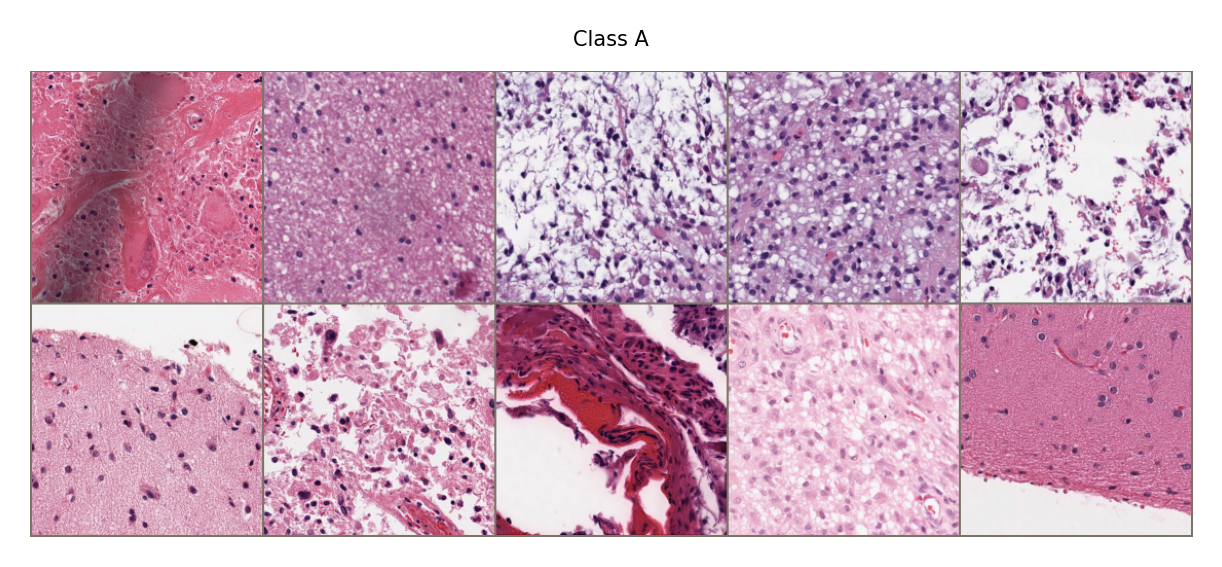

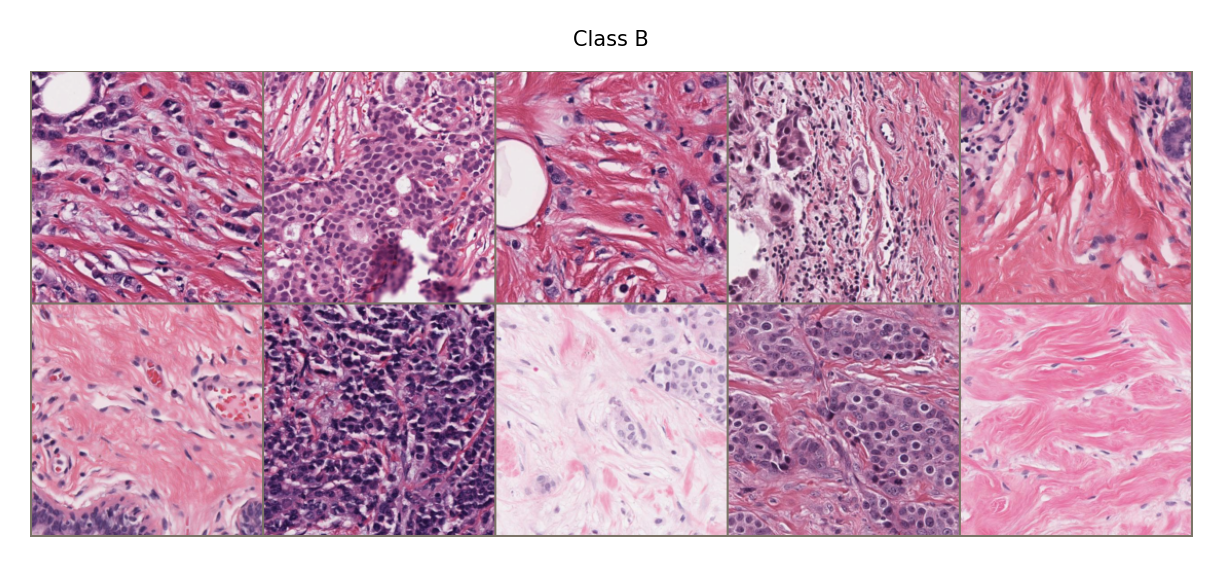

In [9]:
from histul.helpers.images import plot_tensor, plot_confusion_mat

inputs_class_a = [test_dataset[i][0] for i in range(0, 40, 4)]
inputs_class_b = [test_dataset[i][0] for i in range(60, 100, 4)]
plot_tensor(make_grid(inputs_class_a, nrow=5), title="Class A")
plot_tensor(make_grid(inputs_class_b, nrow=5), title="Class B")
df_tsne = tsne(kmeans=kmeans, features_train=features_train)


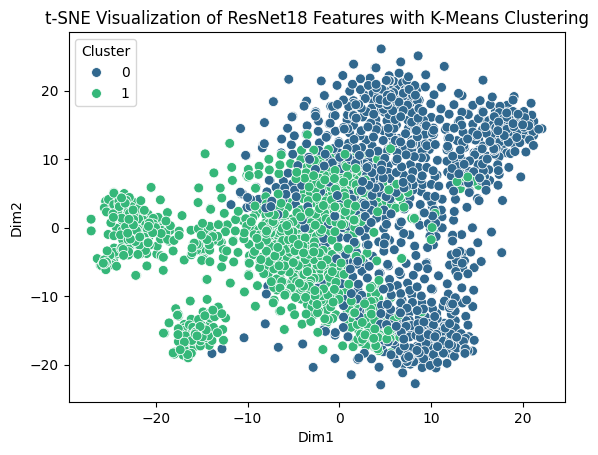

In [10]:
from histul.helpers.images import plot_tsne

plot_tsne(df_tsne)

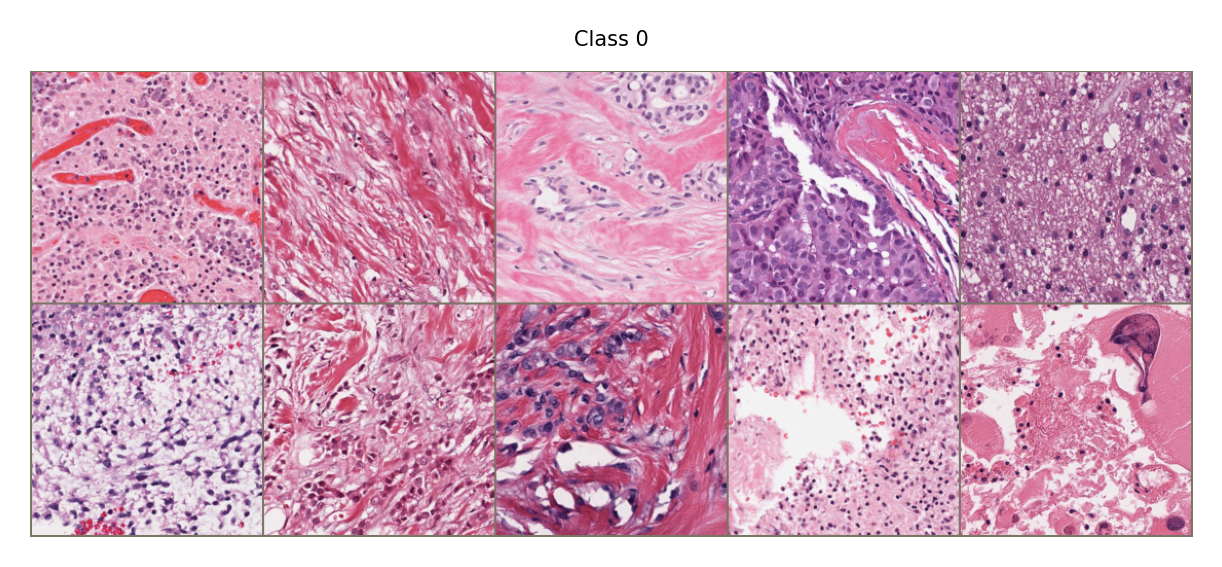

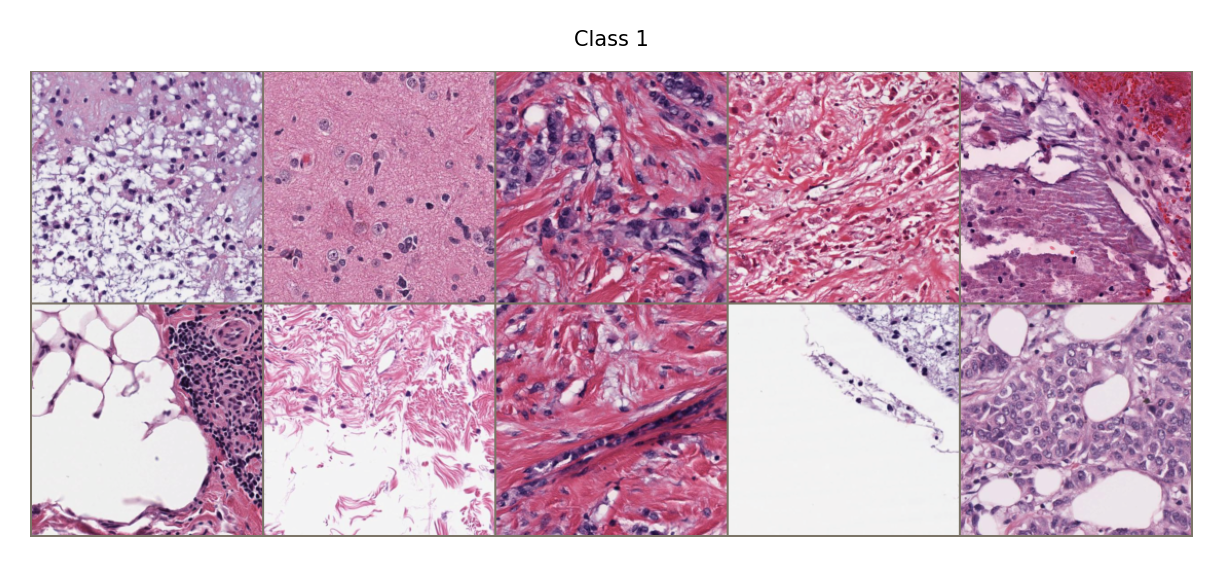

In [11]:
from histul.helpers.images import plot_tensor, plot_confusion_mat

train_dataset_with_labels = list(zip(train_dataset, predicted_labels_train))
class_0_data = [img for img, label in zip(train_dataset, predicted_labels_train) if label == 0]
class_1_data = [img for img, label in zip(train_dataset, predicted_labels_train) if label == 1]
inputs_class_0 = [class_0_data[i][0] for i in range(1, 49, 5)]
inputs_class_1 = [class_1_data[i][0] for i in range(1, 49, 5)]
plot_tensor(make_grid(inputs_class_0, nrow=5), title="Class 0")
plot_tensor(make_grid(inputs_class_1, nrow=5), title="Class 1")


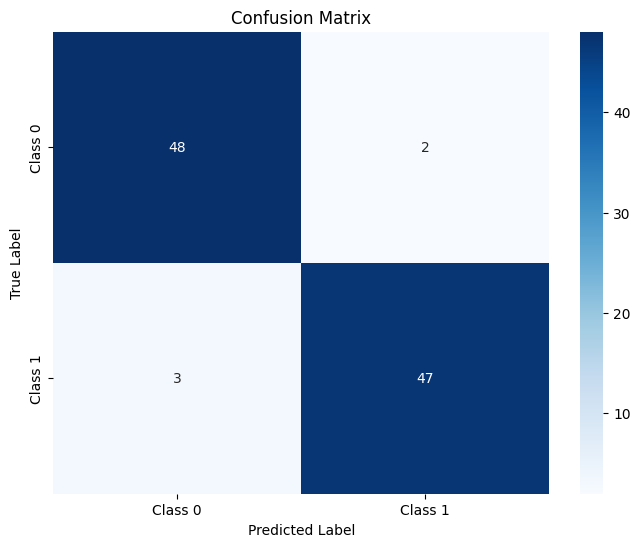

In [12]:
plot_confusion_mat(test_labels, predicted_labels_test)

In [13]:
save_results(file_names_test=file_names_test, predicted_labels_test=predicted_labels_test,
             output_name_test="test_results.csv", file_names_train=file_names_train,
             predicted_labels_train=predicted_labels_train, output_name_train="train_results.csv")
